In [141]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from scipy.signal import savgol_filter
import pandas as pd

In [142]:
class Class_LSTM:
    
    def __init__(self, inputData, window):
        self.df = inputData
        self.meanDf = self.df.mean()
        self.stdDf = self.df.std()
        self.smoothBool = 0
        self.dfNorm = (self.df - self.meanDf) / self.stdDf
        self.window = window
    
    def function_TimeSeriesGenerator(self):
        self.listData = np.array([])
        self.listLabel = np.array([])
        if self.smoothBool == 0:
            for i in range(len(self.dfNorm)-self.window):
                self.tmp_data = self.dfNorm[i:i+self.window]
                self.tmp_label = self.dfNorm[i+self.window]
                self.listData = np.append(self.listData, self.tmp_data)
                self.listLabel = np.append(self.listLabel, self.tmp_label)
            self.arrayData = np.reshape(self.listData, (i+1, self.window,1))
            self.paramShape = (self.window, 1)
        else:
            for i in range(len(self.dfSmooth)-self.window):
                self.tmp_data = self.dfSmooth[i:i+self.window]
                self.tmp_label = self.dfSmooth[i+self.window]
                self.listData = np.append(self.listData, self.tmp_data)
                self.listLabel = np.append(self.listLabel, self.tmp_label)
            self.arrayData = np.reshape(self.listData, (i+1, self.window,1))
            self.paramShape = (self.window, 1)
            

        return self.arrayData, self.listLabel, self.paramShape
    
    def function_Smooth(self, window2):
        self.savgolWindow = window2
        if self.savgolWindow == 0:
            self.smoothBool = 0
        else:
            self.dfSmooth = savgol_filter(self.dfNorm, self.savgolWindow, 2)
            self.smoothBool = 1
        
    
        

    def functionLSTM_Model(self, input_layer, nbHidden=0, drop_out=0):
        self.inputLayer = input_layer
        self.hiddenLayers = nbHidden
        self.lstmShape = np.shape(self.arrayData[1])
        self.drop = drop_out
        self.output_layer = 1
        self.model = Sequential()
        #INPUT LAYER
        if self.hiddenLayers == 0:
            self.model.add(LSTM(self.inputLayer, input_shape = self.lstmShape, return_sequences=False))
            if self.drop != 0:
                    self.model.add(Dropout(self.drop))
        else:
            self.model.add(LSTM(self.inputLayer, input_shape = self.lstmShape, return_sequences=True))
            if self.drop != 0:
                    self.model.add(Dropout(self.drop))

        #HIDDEN LAYER    
        for i in range(0,self.hiddenLayers):
            if i+1 == self.hiddenLayers:
                self.model.add(LSTM(self.inputLayer))
                if self.drop != 0:
                    self.model.add(Dropout(self.drop))
            else:
                self.model.add(LSTM(self.inputLayer, return_sequences=True))
                if self.drop != 0:
                    self.model.add(Dropout(self.drop))
        adamOpti = Adam(lr = 0.001)        
        self.model.add(Dense(1, activation = "linear"))
        self.model.compile(loss='mean_squared_error', optimizer=adamOpti)

        return self.model
    
    def function_Summary(self):
        print(self.model.summary())
    
    def function_Training(self, epok=100, bs=1, val_split=0.2):
        self.epk = epok
        self.sizeBatch = bs
        self.split = val_split
        self.model.fit(self.arrayData, self.listLabel, 
                       epochs=self.epk, 
                       batch_size=self.sizeBatch, 
                       verbose=2, 
                       validation_split=self.split)
        

    def function_Nostradamus(self, windowPredict, plot=True, xmin=0):
        self.X_min = xmin
        self.plot_want = plot
        if self.smoothBool ==0:
            self.predictWindow = windowPredict
            self.nostradamus = np.array(self.dfNorm[-self.window:])
            self.nostradamus = np.reshape(self.nostradamus, (1,self.window,1))
            self.prediction = np.array([])
            for i in range(self.predictWindow):
                self.tmp_pred = self.model.predict(self.nostradamus[i:i+1])
                self.pred_tmp = np.append(self.nostradamus[i], self.tmp_pred)
                self.pred_tmp = self.pred_tmp[1:]
                self.pred_tmp = np.reshape(self.pred_tmp, (self.window,1))               
                self.nostradamus = np.append(self.nostradamus, self.pred_tmp)              
                self.nostradamus = np.reshape(self.nostradamus, (i+2,self.window,1))               
                self.prediction = np.append(self.prediction, self.tmp_pred)
                
            if self.plot_want == True:
                plt.plot((np.linspace(len(self.dfNorm),
                                      len(self.dfNorm) + self.predictWindow - 1,
                                      self.predictWindow)),
                                      self.prediction*self.stdDf+self.meanDf )
                plt.plot(np.linspace(0,len(self.dfNorm) - 1,
                                     len(self.dfNorm)), 
                                     self.dfNorm*self.stdDf+self.meanDf)
                plt.xlim(self.X_min, len(self.dfNorm) + self.predictWindow + 1)
            
            
        else:
            self.predictWindow = windowPredict
            self.nostradamus = np.array(self.dfNorm[-self.window:])
            self.nostradamus = np.reshape(self.nostradamus, (1,self.window,1))
            self.prediction = np.array([])
            for i in range(self.predictWindow):
                self.tmp_pred = self.model.predict(self.nostradamus[i:i+1])
                self.pred_tmp = np.append(self.nostradamus[i], self.tmp_pred)
                self.pred_tmp = self.pred_tmp[1:]
                self.pred_tmp = np.reshape(self.pred_tmp, (self.window,1))               
                self.nostradamus = np.append(self.nostradamus, self.pred_tmp)              
                self.nostradamus = np.reshape(self.nostradamus, (i+2,self.window,1))               
                self.prediction = np.append(self.prediction, self.tmp_pred)
                
            if self.plot_want == True:
                plt.plot((np.linspace(len(self.dfSmooth),
                                      len(self.dfSmooth) + self.predictWindow - 1,
                                      self.predictWindow)),
                                      self.prediction*self.stdDf+self.meanDf )
                plt.plot(np.linspace(0,len(self.dfSmooth) - 1,
                                     len(self.dfSmooth)), 
                                     self.dfSmooth*self.stdDf+self.meanDf)
                plt.xlim(self.X_min, len(self.dfSmooth) + self.predictWindow + 1)
                
        
            

        return self.prediction
    
    
    def function_Plot(self):
        if self.smoothBool == 0:
            self.X = np.linspace(0, len(self.dfNorm) - 1 ,len(self.dfNorm))
            plt.plot(self.X, self.dfNorm, c = 'darkblue')
        else:
            self.X = np.linspace(0, len(self.dfSmooth) - 1 ,len(self.dfSmooth))
            plt.plot(self.X, self.dfSmooth, c = 'darkblue')
    
    
    def log_Df(self):
        if self.smoothBool == 0:
            self.log_df = np.log(self.dfNorm*self.stdDf+self.meanDf + 1)
        else:
            self.log_df = np.log(self.dfSmooth*self.stdDf+self.meanDf + 1)
        return self.log_df
            
      

In [143]:
covid_df = pd.read_csv('donnees-hospitalieres-nouveaux-covid19-2021-02-23-19h03.csv', sep=';')
#covid_df = covid_df.loc[covid_df['dep'] == '06']
df_2 = covid_df.groupby('jour')['incid_dc', 'incid_rea', 'incid_hosp'].sum()
df_2.tail(21)

,incid_dc,incid_rea,incid_hosp
jour,,,
2021-02-03,358,275,1882
2021-02-04,360,275,1752
2021-02-05,296,255,1719
2021-02-06,191,168,1126
2021-02-07,171,160,790
2021-02-08,460,356,1893
2021-02-09,439,334,1931
2021-02-10,297,282,1525
2021-02-11,371,269,1618


In [144]:
covid = Class_LSTM(df_2['incid_hosp'],28)

In [147]:
covid.function_Smooth(19)

C:\Users\Carcouss\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


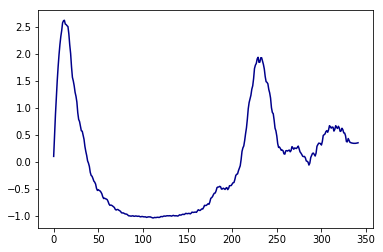

In [148]:
covid.function_Plot()

In [149]:
yaya = covid.log_Df()
yaya[1]

7.323352343672892

In [150]:
plt.plot(yaya.index, yaya[0:])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [151]:
covid.function_TimeSeriesGenerator()

(array([[[0.10458816],
         [0.50981471],
         [0.87840116],
         ...,
         [1.21607075],
         [1.10950847],
         [0.91183937]],
 
        [[0.50981471],
         [0.87840116],
         [1.21034752],
         ...,
         [1.10950847],
         [0.91183937],
         [0.78882762]],
 
        [[0.87840116],
         [1.21034752],
         [1.50565378],
         ...,
         [0.91183937],
         [0.78882762],
         [0.7484051 ]],
 
        ...,
 
        [[0.62704176],
         [0.6471807 ],
         [0.64297527],
         ...,
         [0.34624437],
         [0.34545054],
         [0.34606754]],
 
        [[0.6471807 ],
         [0.64297527],
         [0.57286291],
         ...,
         [0.34545054],
         [0.34606754],
         [0.34809536]],
 
        [[0.64297527],
         [0.57286291],
         [0.60498458],
         ...,
         [0.34606754],
         [0.34809536],
         [0.351534  ]]]),
 array([ 7.88827622e-01,  7.48405105e-01,  6.67087268e-

In [152]:
covid.functionLSTM_Model(32,0, 0.2)

In [153]:
covid.function_Summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [154]:
covid.functionLSTM_Model(32,0, 0.2)
covid.function_Training(epok=5, val_split=0.2)

Train on 251 samples, validate on 63 samples
Epoch 1/5
 - 12s - loss: 0.1127 - val_loss: 0.0052
Epoch 2/5
 - 7s - loss: 0.0196 - val_loss: 0.0071
Epoch 3/5
 - 6s - loss: 0.0146 - val_loss: 0.0067
Epoch 4/5
 - 7s - loss: 0.0170 - val_loss: 0.0048
Epoch 5/5
 - 7s - loss: 0.0130 - val_loss: 0.0083


array([0.36286968, 0.3955009 , 0.43191302, 0.47120643, 0.52160114,
       0.57919639, 0.63072693, 0.68203801, 0.74097842, 0.80516374,
       0.87305725, 0.95054543, 1.03328633, 1.10374033, 1.17480838,
       1.2506603 , 1.32366288, 1.39649773, 1.46885502, 1.54046702,
       1.59500492, 1.63760865, 1.67702329, 1.70939982, 1.73306918,
       1.75470364, 1.77238083, 1.77052772])

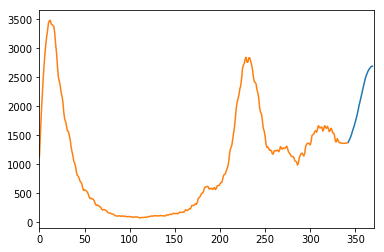

In [155]:
covid.function_Nostradamus(28, xmin = 0, plot = True)

In [158]:
covid.functionLSTM_Model(12,3, 0.2)
covid.function_Training(epok=5, val_split=0.2)

Train on 251 samples, validate on 63 samples
Epoch 1/5
 - 28s - loss: 0.2926 - val_loss: 0.0151
Epoch 2/5
 - 19s - loss: 0.0974 - val_loss: 0.0666
Epoch 3/5
 - 20s - loss: 0.0552 - val_loss: 0.0837
Epoch 4/5
 - 24s - loss: 0.0552 - val_loss: 0.1531
Epoch 5/5
 - 36s - loss: 0.0486 - val_loss: 0.0156


array([0.20925425, 0.20508637, 0.20611352, 0.20825747, 0.2182052 ,
       0.23318151, 0.23689564, 0.23206027, 0.22759821, 0.22387703,
       0.22111198, 0.22635029, 0.23882051, 0.24141465, 0.2424861 ,
       0.24816228, 0.25429001, 0.26424766, 0.28007621, 0.30442122,
       0.32196447, 0.33324221, 0.34688982, 0.36184171, 0.376973  ,
       0.39948061, 0.43084118, 0.45168707])

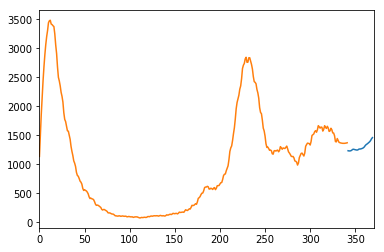

In [159]:
covid.function_Nostradamus(28, xmin = 0, plot = True)